In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

# from utils.Auger.SD import Monitoring

from utils.binaries import *
from utils.plotting import *

def is_winter_night(df):
    mask = []
    for _, row in df.iterrows():
        t = row['t']

        if t.month not in [6, 7]:
            mask.append(False)
            continue
        if not (0 <= t.hour < 6): 
            mask.append(False)
            continue

        mask.append(True)

    return mask

def is_summer_day(df):
    mask = []
    for _, row in df.iterrows():
        t = row['t']

        if t.month not in [1, 12]: 
            mask.append(False)
            continue
        if not (12 <= t.hour < 18): 
            mask.append(False)
            continue

        mask.append(True)

    return mask

14:49:48 (   +1.6s) [INFO   ] -- import logging
14:49:48 (  +134ms) [INFO   ] -- import numpy as np
14:49:48 (    +5ms) [INFO   ] -- import uncertainties
14:49:48 (  +228ms) [INFO   ] -- import pandas as pd
14:49:48 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
14:49:48 (    +2ms) [INFO   ] -- import binaries.tools as tools
14:49:49 (  +302ms) [INFO   ] -- import matplotlib.pyplot as plt
14:49:49 (  +352ms) [INFO   ] -- import seaborn as so
14:49:49 (    +7ms) [DEBUG  ] -- font size set to 9.5
14:49:49 (    +1ms) [DEBUG  ] -- label size set to 13.0
14:49:49 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
14:49:49 (    +1ms) [DEBUG  ] -- markersize set to 2.0
14:49:49 (    +1ms) [DEBUG  ] -- usetex set to False
14:49:49 (    +2ms) [INFO   ] -- import plotting.tools as plot


In [2]:
import datetime

GPS_OFFSET = 315964800
data = pd.read_csv('/cr/tempdata01/filip/SSDCalib/BootstrapHistos/estimates.txt', sep=' ', index_col=False)
data = data.dropna()

data['id'] = data['id'].astype(str)
data['t'] = [datetime.datetime.fromtimestamp(d + GPS_OFFSET) for d in data['t']]

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

stations = np.unique(data['id'])

In [3]:
container = []
container_summer = []
container_winter = []

summer = data[is_summer_day(data)]
winter = data[is_winter_night(data)]
least_data_points = 30

for station in stations:
    df = data[data["id"] == station]
    df_summer = summer[summer["id"] == station]
    df_winter = winter[winter["id"] == station]
    mip_and_sigma_and_bias = [station, df['mip'].mean()]
    mip_and_sigma_and_bias_summer = [station, df_summer['mip'].mean()]
    mip_and_sigma_and_bias_winter = [station, df_winter['mip'].mean()]

    for col in data.columns[3:]:
            mip_and_sigma_and_bias.append([df[col].mean(), df[col].std()])
            mip_and_sigma_and_bias_summer.append([df_summer[col].mean(), df_summer[col].std()])
            mip_and_sigma_and_bias_winter.append([df_winter[col].mean(), df_winter[col].std()])

    if len(df) >= least_data_points:
        container.append(mip_and_sigma_and_bias)
    if len(df_summer) >= least_data_points:
        container_summer.append(mip_and_sigma_and_bias_summer)
    if len(df_winter) >= least_data_points:
        container_winter.append(mip_and_sigma_and_bias_winter)

performance = pd.DataFrame(container, columns=['id', 'mip', *data.columns[3:]])
performance_summer = pd.DataFrame(container_summer, columns=performance.columns)
performance_winter = pd.DataFrame(container_winter, columns=performance.columns)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
14:53:08 ( +198.8s) [DEBUG  ] -- font size set to 9.5
14:53:08 (    +2ms) [DEBUG  ] -- label size set to 13.0
14:53:08 (    +0ms) [DEBUG  ] -- figure size set to [3.3, 2.5]
14:53:08 (    +1ms) [DEBUG  ] -- markersize set to 2.0
14:53:08 (    +1ms) [DEBUG  ] -- usetex set to True
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following fami

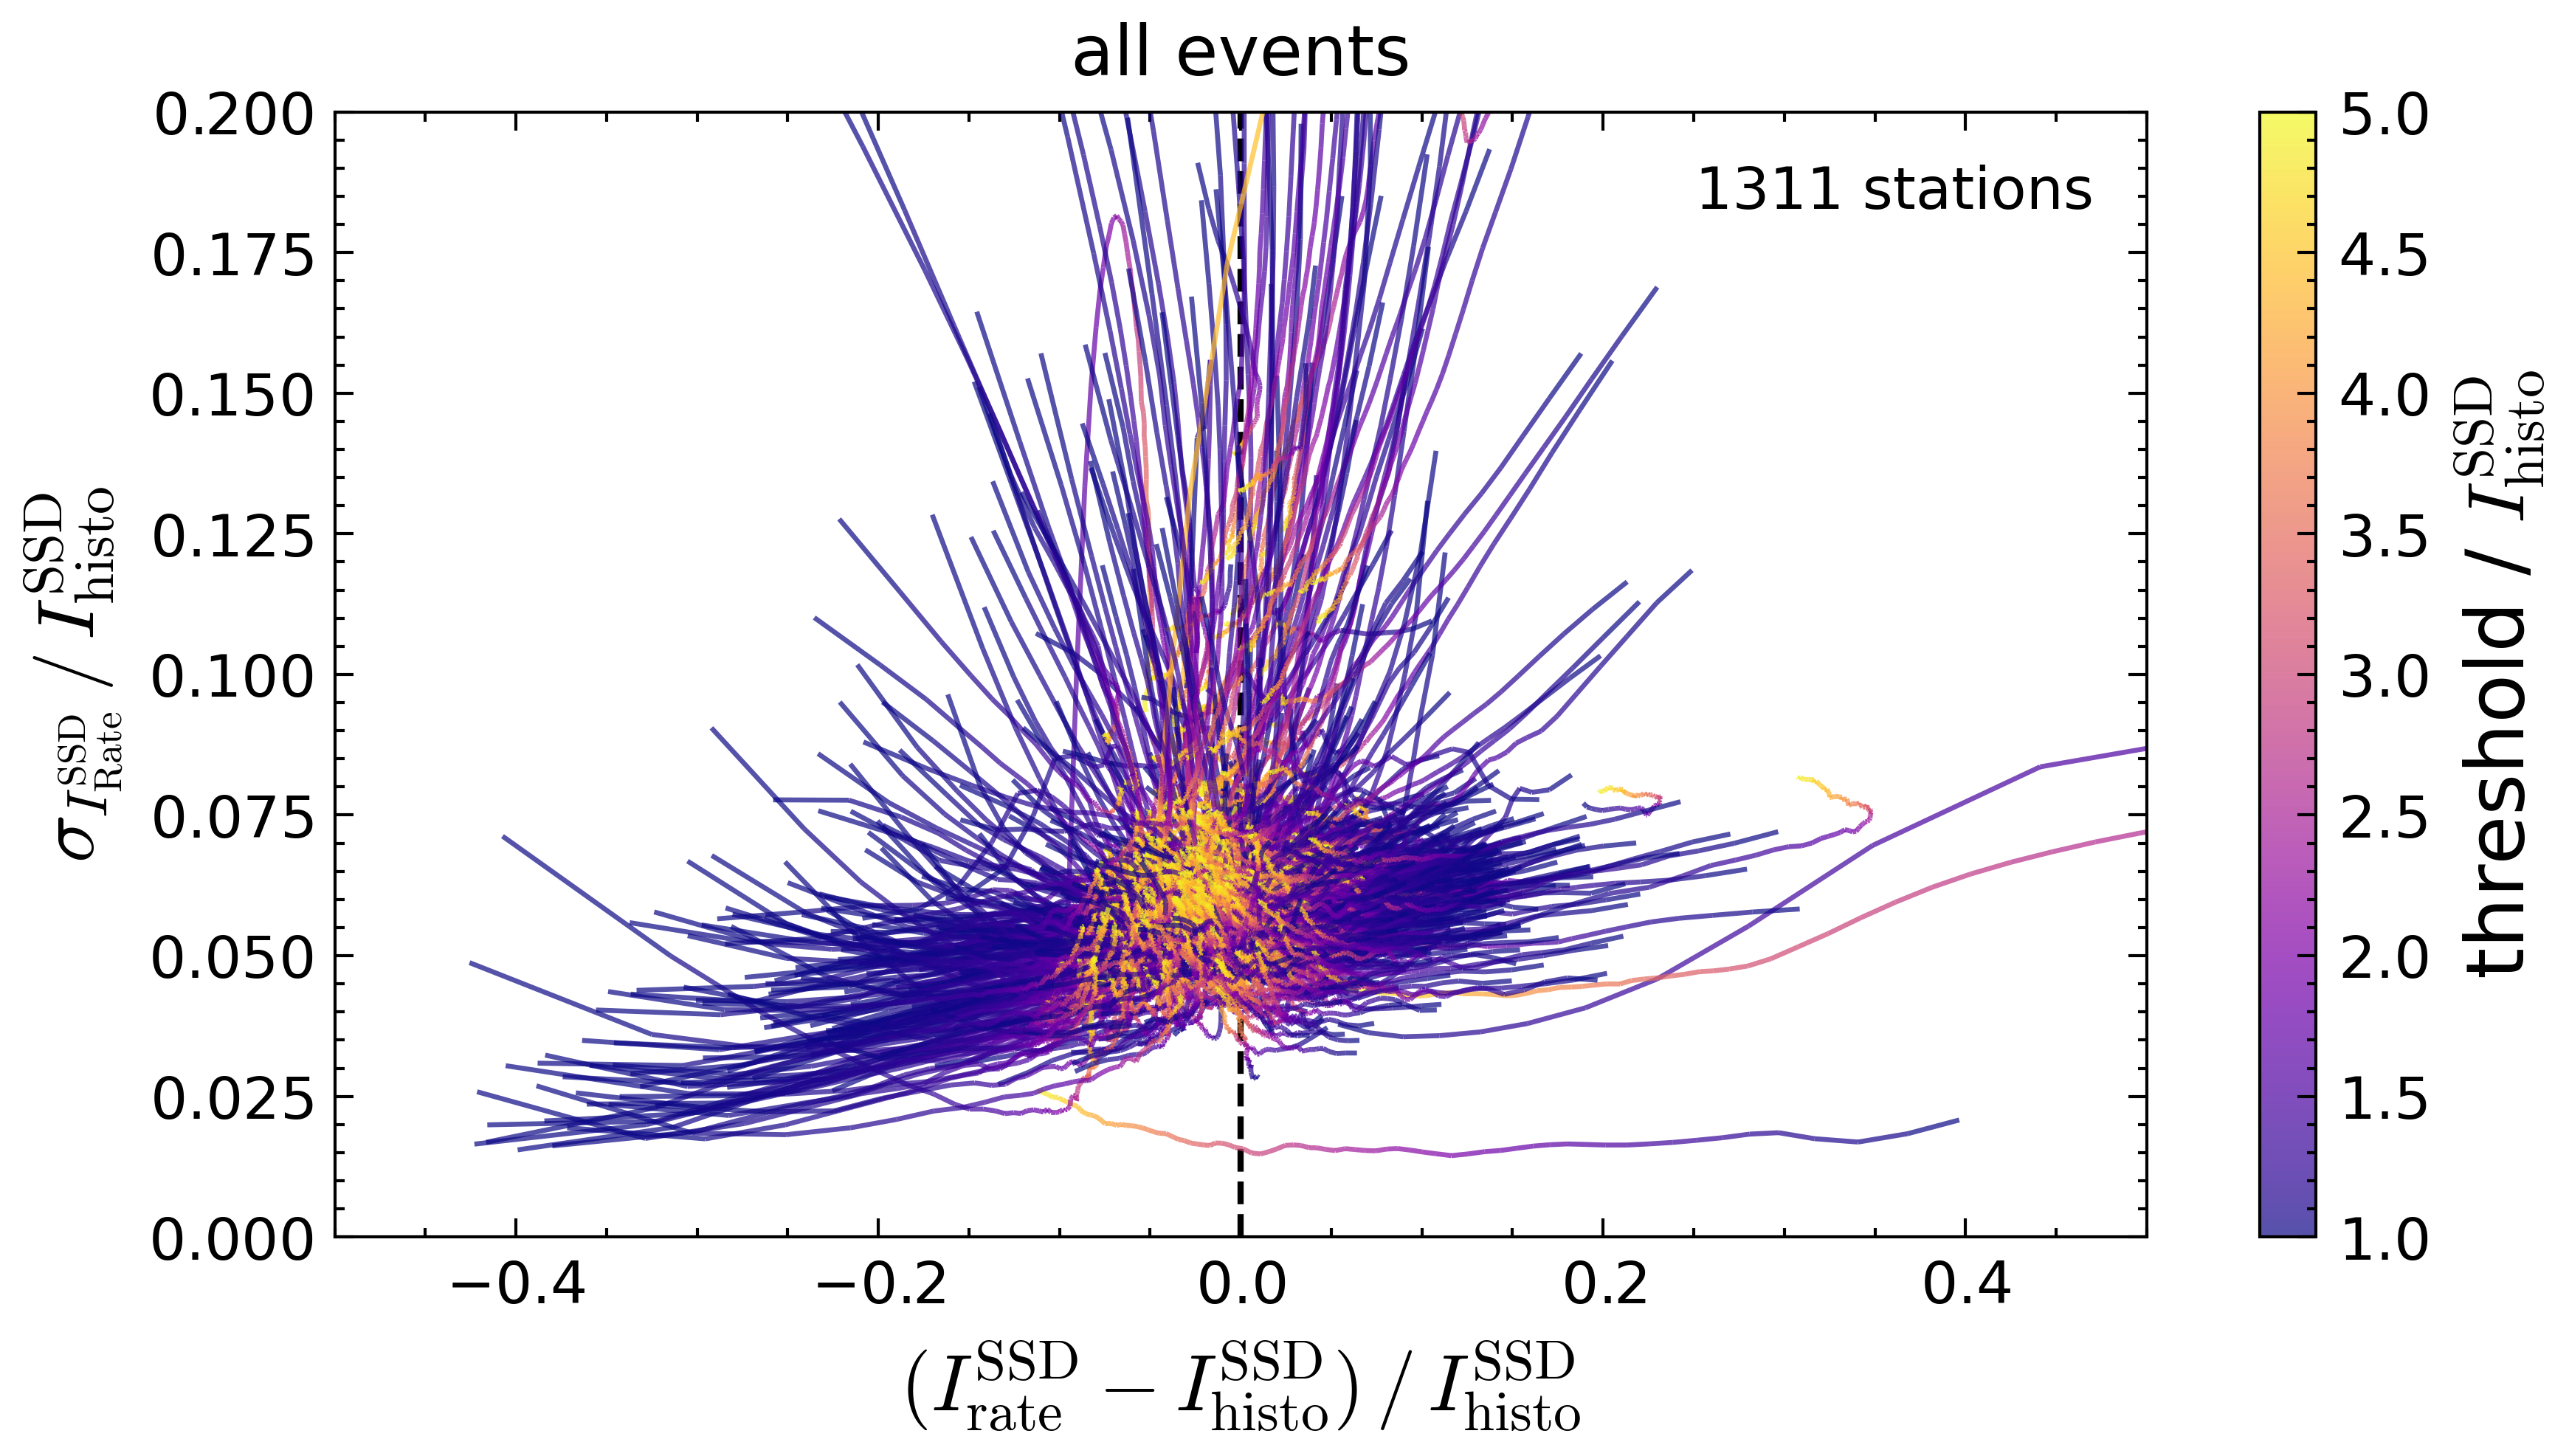

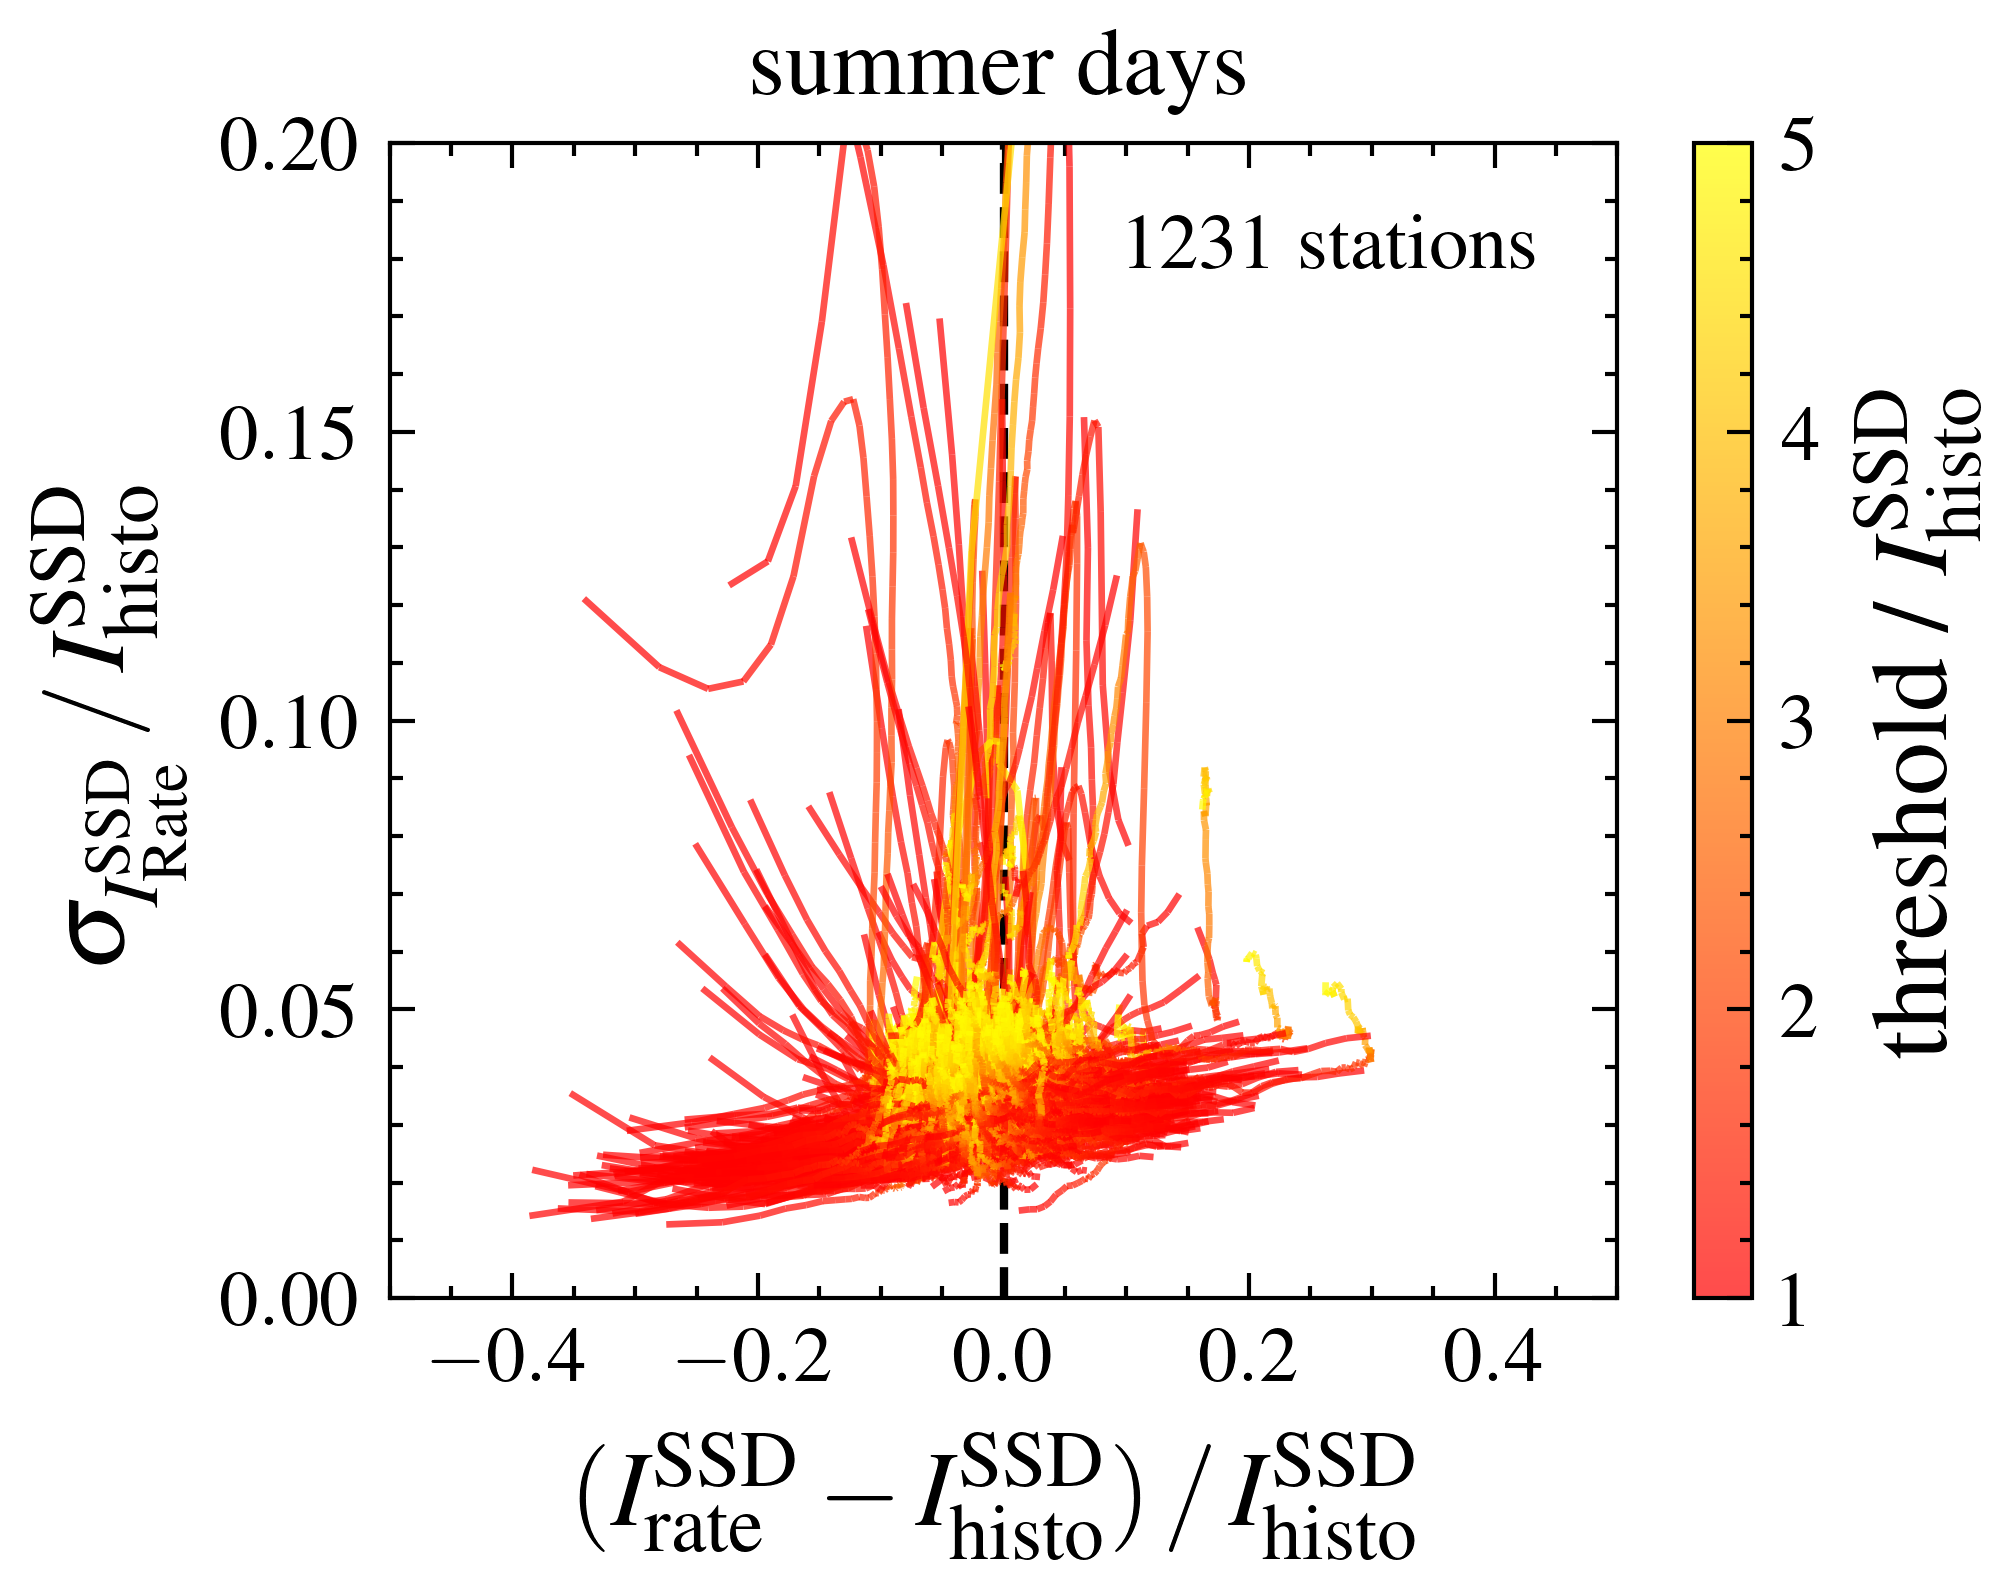

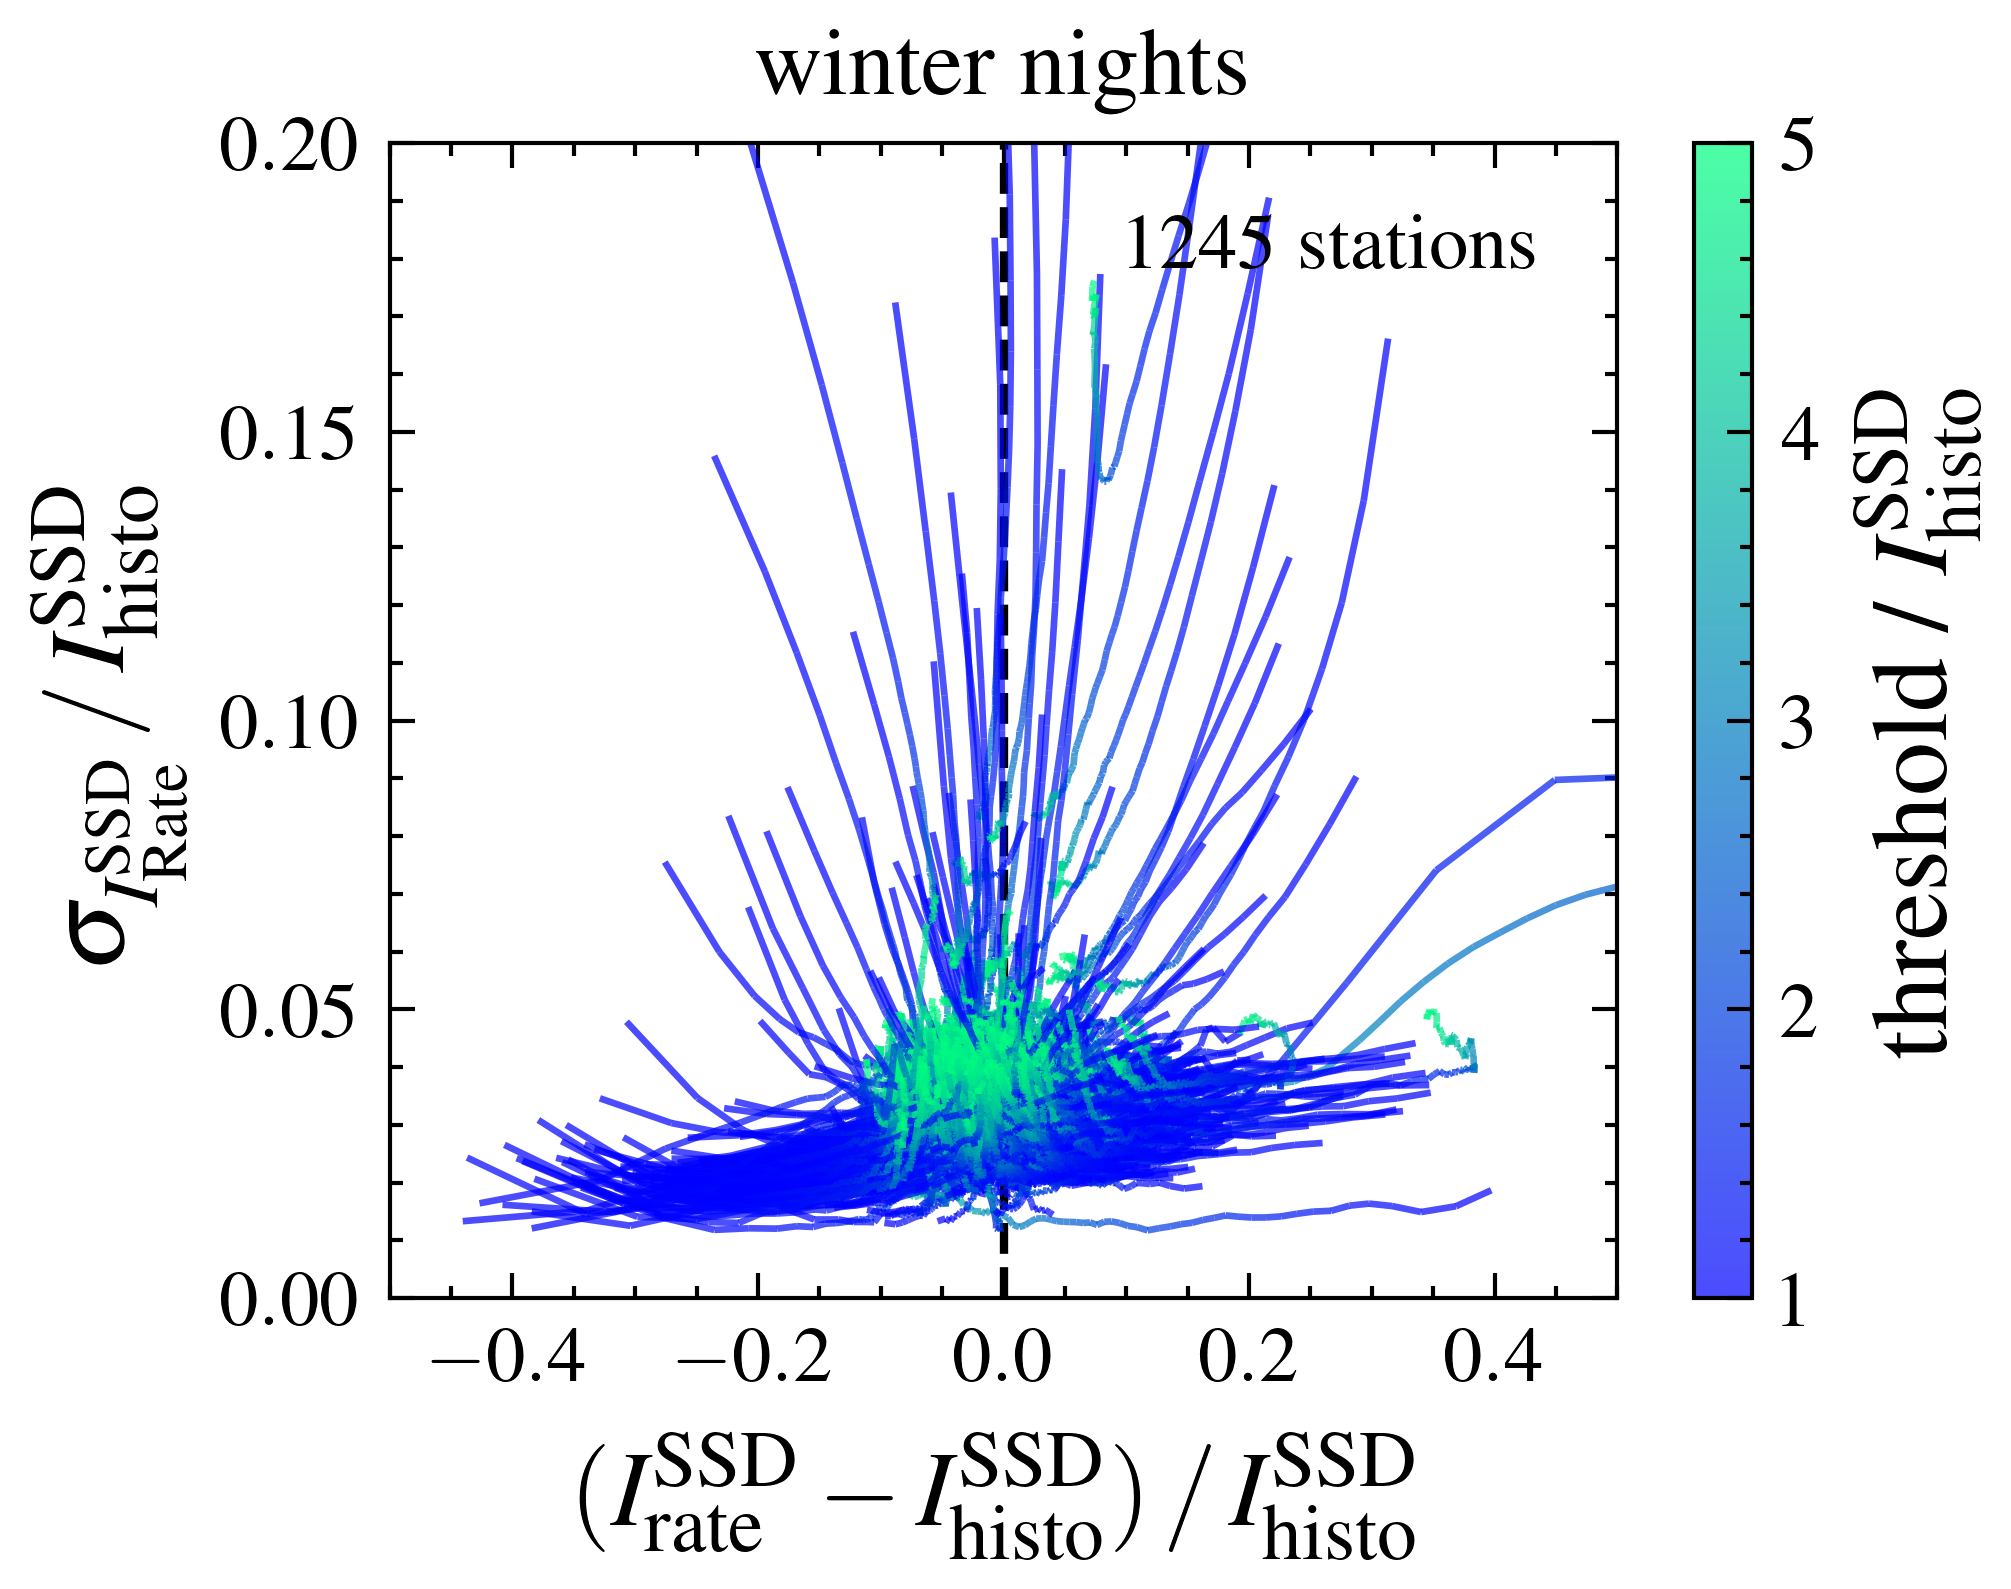

In [4]:
from matplotlib.collections import LineCollection

N = np.linspace(1, 5, len(performance.columns[2:]))
dfs = [performance, performance_summer, performance_winter]
cmap = ['plasma', 'autumn', 'winter']
title = ["all events", "summer days", "winter nights"]

for i in range(3):

    if i == 1:
        set_plt_style('double tex')

    fig = plt.figure()
    ax = plt.gca()

    for _, station in dfs[i].iterrows():
        mip = station['mip']

        x = (station[2:].map(lambda _: _[0]).values - mip) / mip
        y = station[2:].map(lambda _: _[1]).values / mip

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=cmap[i], alpha=0.7)
        lc.set_array(N)
        lc.set_linewidth(0.8)
        l = ax.add_collection(lc)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 0.2)
    ax.axvline(0, c='k', ls='--', lw=1, zorder=-10)
    ax.set_xlabel("$(I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo})\,/\,I^\mathrm{SSD}_\mathrm{histo}$")
    ax.set_ylabel("$\sigma_{I^\mathrm{SSD}_\mathrm{Rate}}\,/\,I^\mathrm{SSD}_\mathrm{histo}$")
    fig.colorbar(l, ax=ax, label="threshold / $I^\mathrm{SSD}_\mathrm{histo}$")
    ax.legend(title=f'{len(dfs[i])} stations')
    ax.set_title(title[i])

    fig.savefig(f'/cr/users/filip/plots/malargue_2024_04/{title[i]}.png')

15:03:56 (  +78.6s) [DEBUG  ] -- font size set to 9.5
15:03:56 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:03:56 (    +1ms) [DEBUG  ] -- figure size set to [3.3, 2.5]
15:03:56 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:03:56 (    +1ms) [DEBUG  ] -- usetex set to True


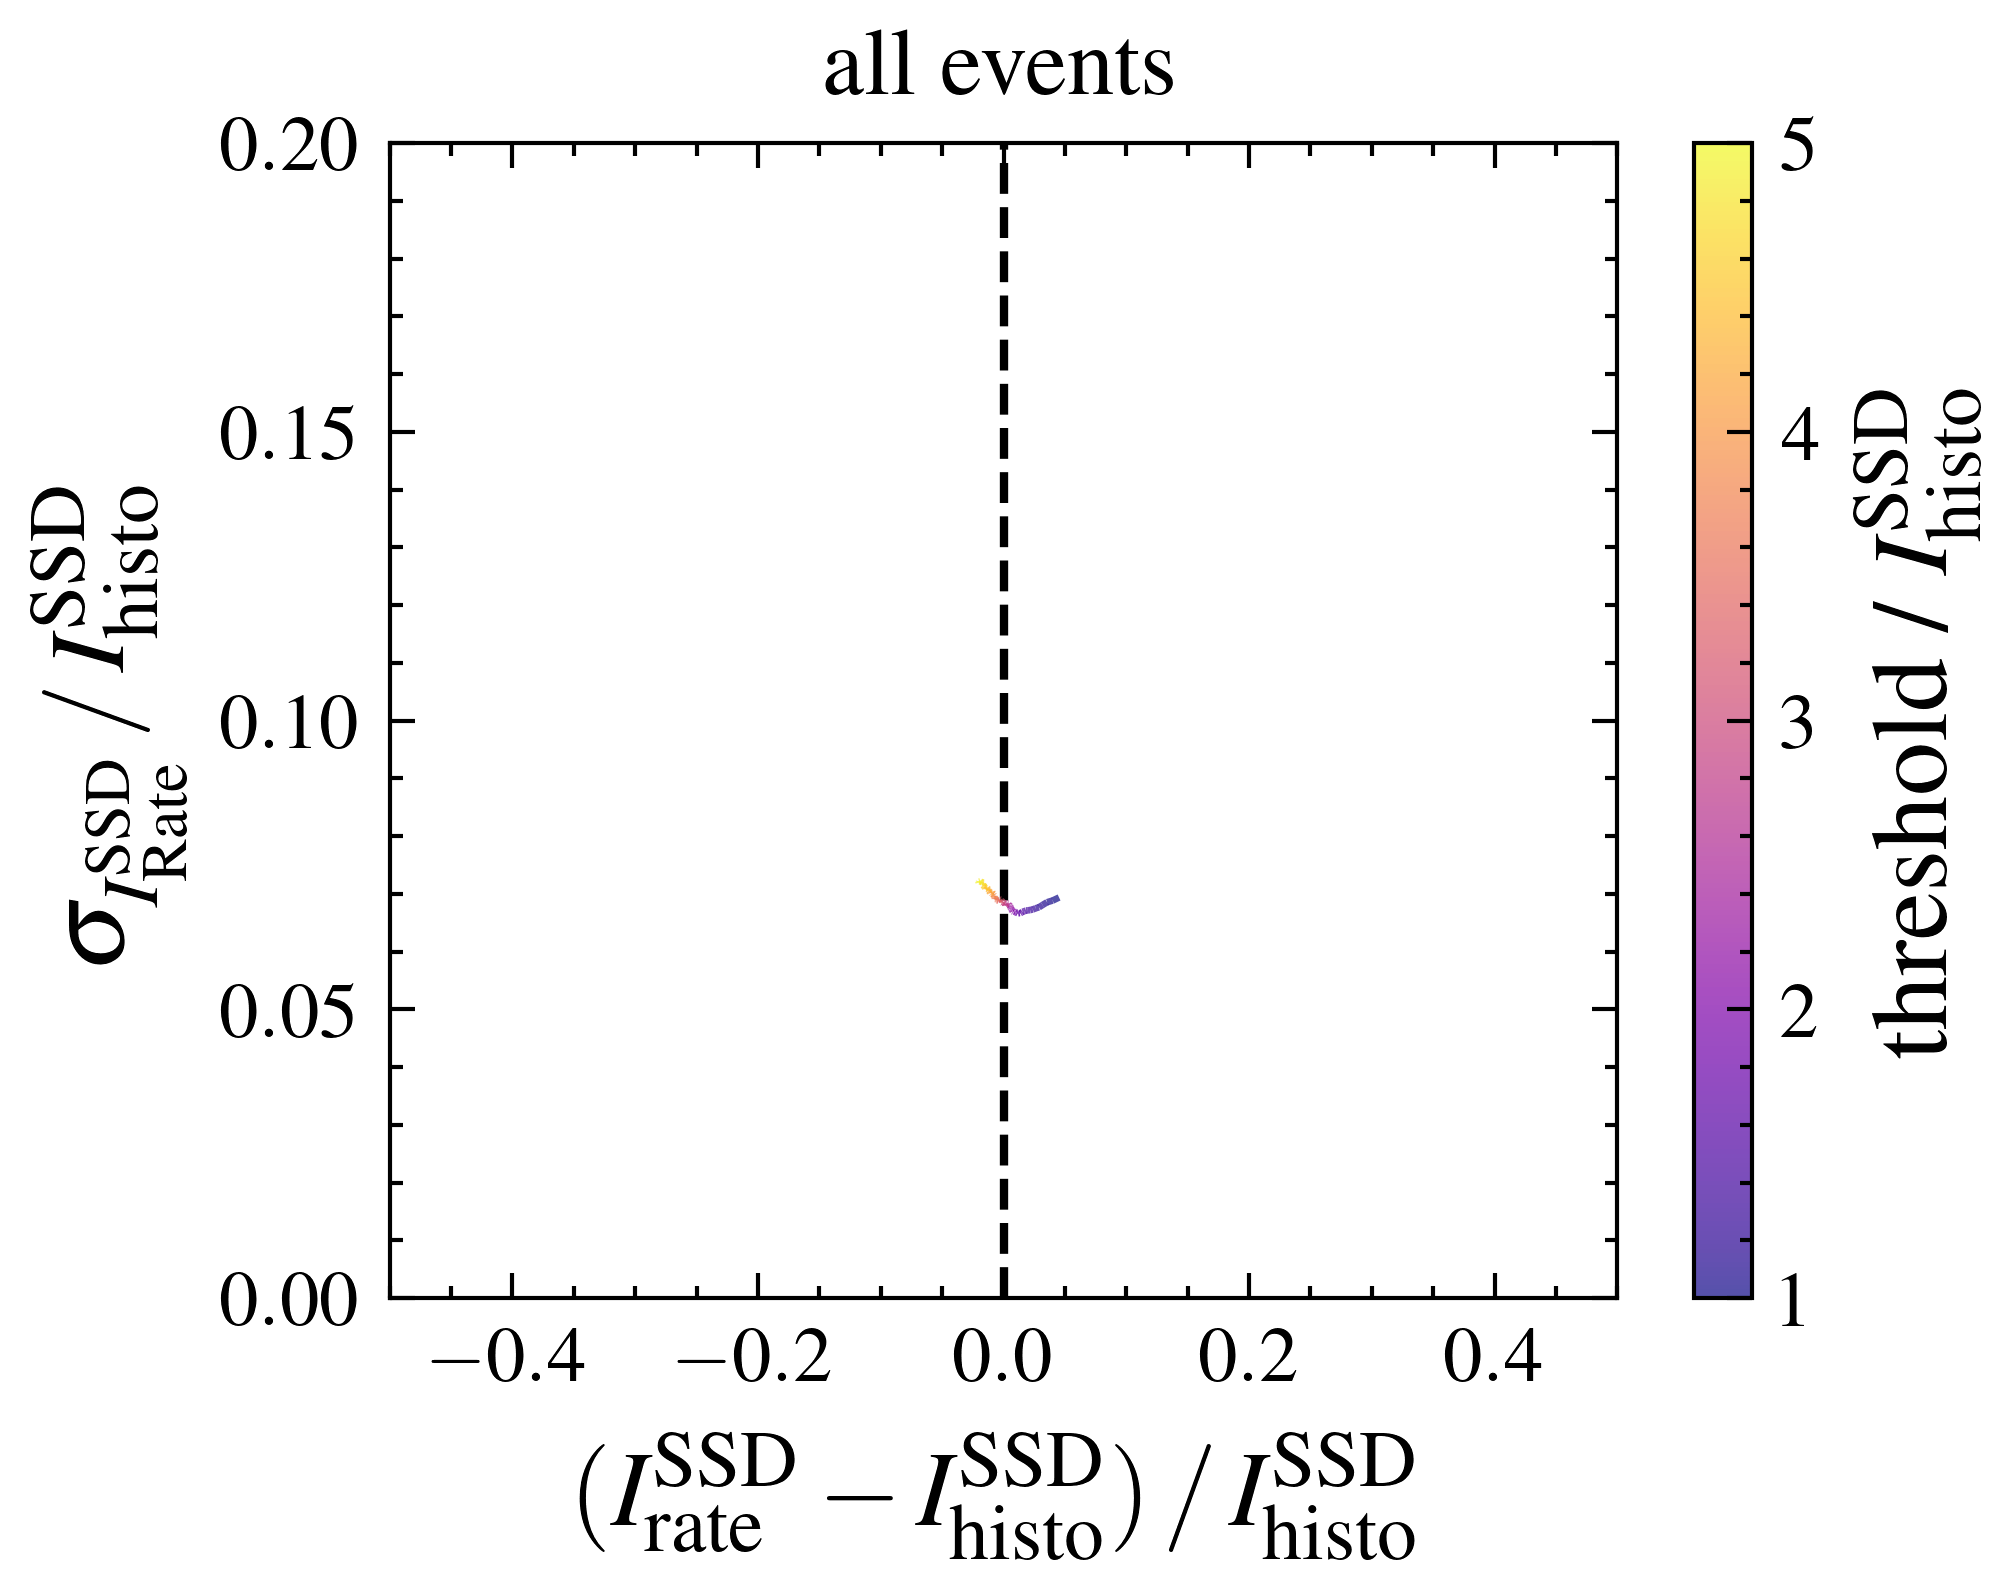

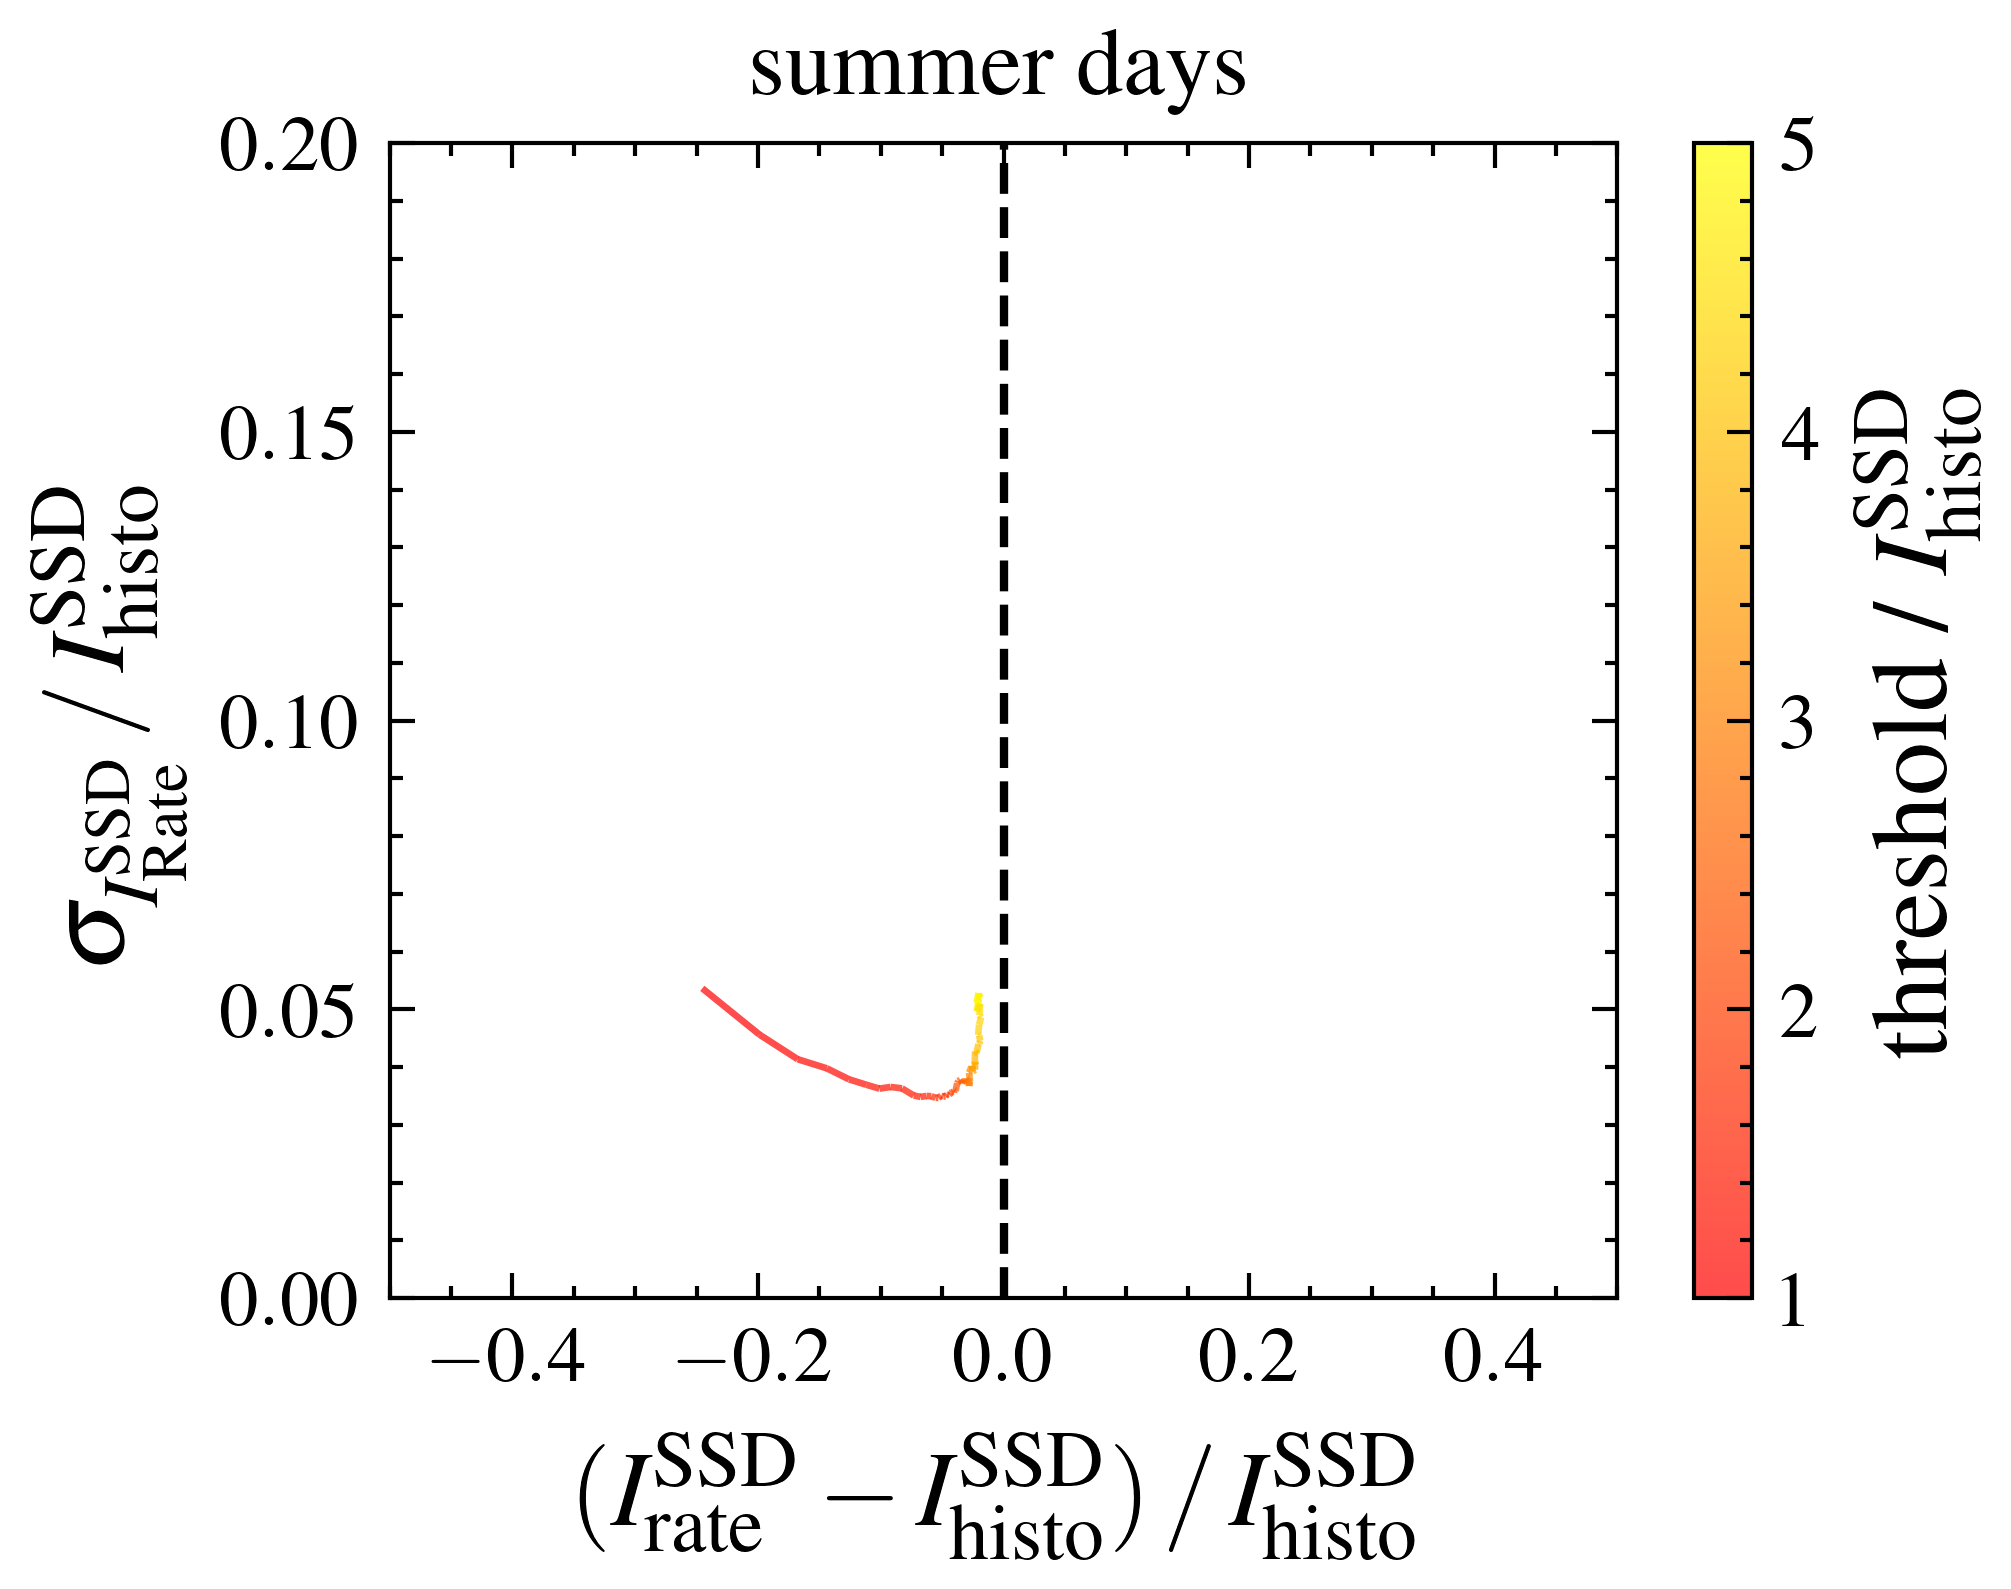

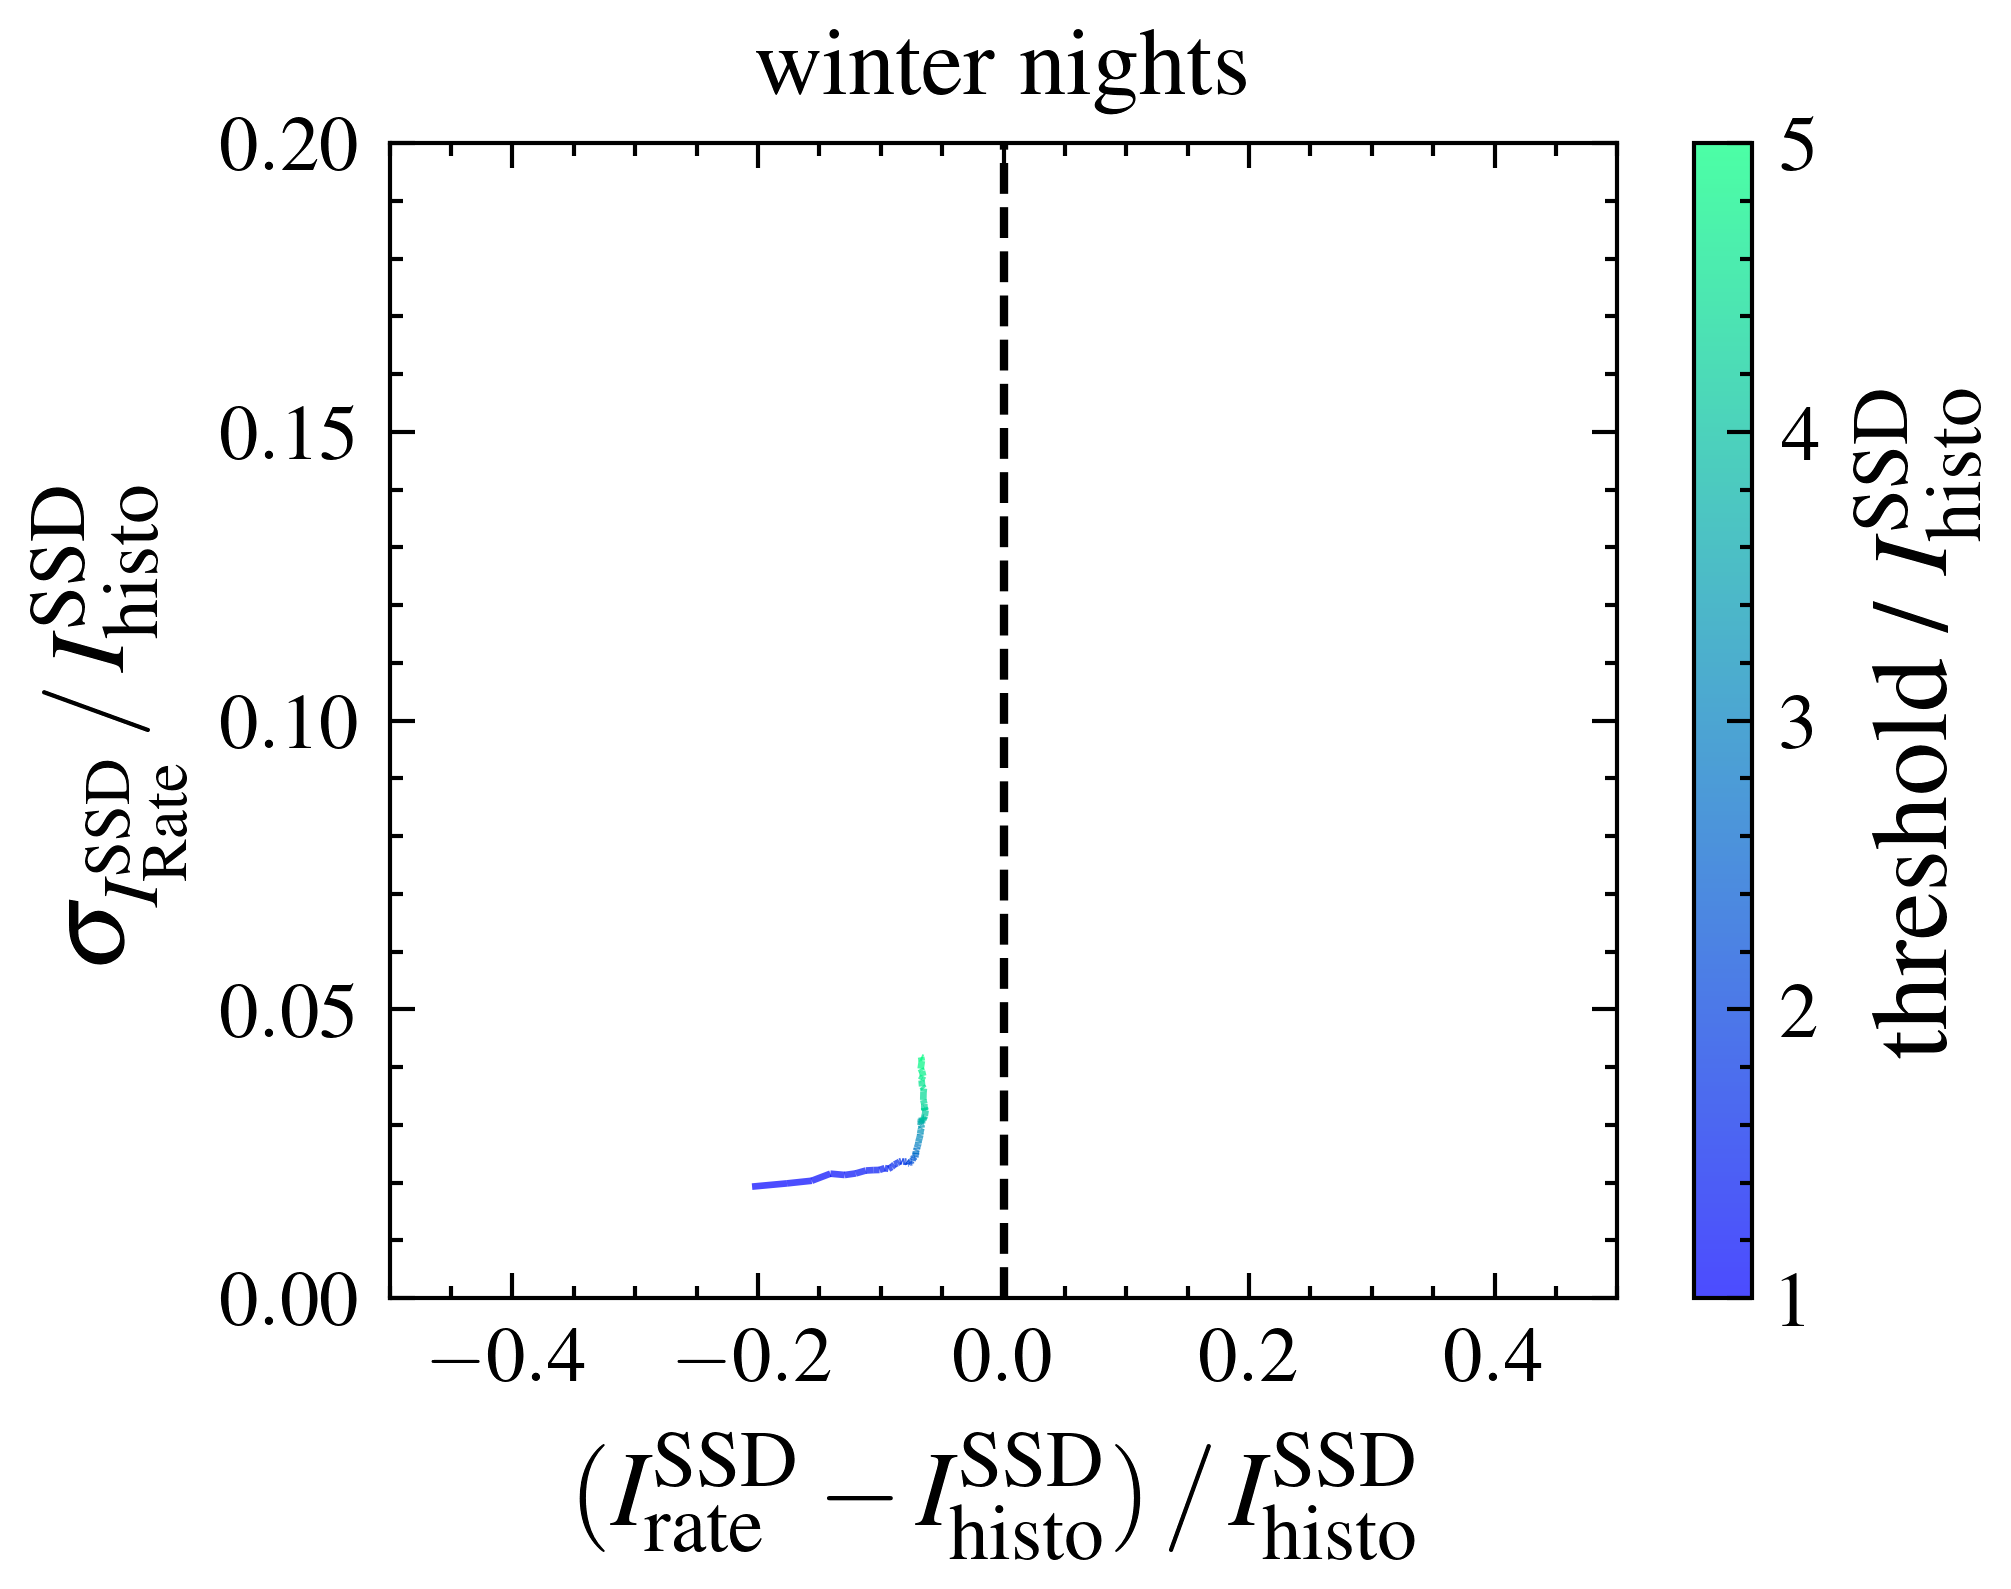

In [9]:
from matplotlib.collections import LineCollection

N = np.linspace(1, 5, len(performance.columns[2:]))
dfs = [performance, performance_summer, performance_winter]
cmap = ['plasma', 'autumn', 'winter']
title = ["all events", "summer days", "winter nights"]

for i in range(3):

    if i == 1:
        set_plt_style('double tex')

    fig = plt.figure()
    ax = plt.gca()

    for _, station in dfs[i].iterrows():

        if _ < 200: continue

        mip = station['mip']

        x = (station[2:].map(lambda _: _[0]).values - mip) / mip
        y = station[2:].map(lambda _: _[1]).values / mip

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=cmap[i], alpha=0.7)
        lc.set_array(N)
        lc.set_linewidth(0.8)
        l = ax.add_collection(lc)

        break

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 0.2)
    ax.axvline(0, c='k', ls='--', lw=1, zorder=-10)
    ax.set_xlabel("$(I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo})\,/\,I^\mathrm{SSD}_\mathrm{histo}$")
    ax.set_ylabel("$\sigma_{I^\mathrm{SSD}_\mathrm{Rate}}\,/\,I^\mathrm{SSD}_\mathrm{histo}$")
    fig.colorbar(l, ax=ax, label="threshold / $I^\mathrm{SSD}_\mathrm{histo}$")
    # ax.legend(title=f'{len(dfs[i])} stations')
    ax.set_title(title[i])

    fig.savefig(f'/cr/users/filip/plots/malargue_2024_04/{title[i]}_single_station.png')